<a href="https://colab.research.google.com/github/PierreM31/Kaggle_Challenge_NYC/blob/master/Neural_Network_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Fare Prediction Playground Competition

The data exploration section presented in this notebook is mainly coming from the notebook of Albert van Breemen [https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration].

## Summary

* [Reading data and first exploration](#start_generic)
    1. [Training data](#start_training)
    2. [Test data](#start_test)
    
    
* [Explore and clean the data](#explore_generic)
    1. [Generic](#explore_generic)
    2. [Location data](#explore_location)
        - [Ploting location data](#explore_location_plot)
        - [Removing datapoints in the water](#explore_location_water)


* [Feature engineering](#feature_engineering)
    1. [Distance](#feature_distance)
        - [Manhattan distance](#feature_distance_manhattan)
        - [Going further](#feature_distance_further)
        - [OpenTripPlanner](#feature_distance_otp)

<a id='start_generic'></a>
## Reading data and first exploration


First thing to do with a new dataset is to explore the data. This means investigating the number of features, their datatype, their meaning and statistics.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

<a id='start_training'></a>
### Training data

As this dataset is huge reading all data would require a lot of memory. Therefore we read a limited number of rows while exploring the data.

In [0]:
# Read data in pandas dataframe
df_train =  pd.read_csv('./all/train.csv', nrows=500_000, parse_dates=["pickup_datetime"])

# List first few rows (datapoints)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# Check datatypes
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [0]:
# Check statistics of the features
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


The following things we can notice (while using 500k datapoints):

- The minimal `fare_amount` is negative. As this does not seem to be realistic we will drop them from the dataset.
- Some of the minimum and maximum longitude/lattitude coordinates are way off. These we will also remove from the dataset (by defining a bounding box for the coordinates, see further).
- The average `fare_amount` is about \$11.4 USD with a standard deviation of \$9.9 USD. When building a predictive model we want to be better than $9.9 USD

<a id='start_test'></a>
### Test data

Read the test data to check the statistics and compare with the training set.

In [0]:
df_test =  pd.read_csv('./all/test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [0]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


<a id='explore_generic'></a>
## Explore and clean the data

### Generic

First let's remove the points of the dataset with a `fare_amount` less than zero

In [0]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 500000
New size: 499979


Then let's check if there is missing data. As this dataset is huge, removing datapoints with missing data probably has no effect on the models beings trained.

In [0]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64


In [0]:
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 499979
New size: 499974


<a id='explore_location'></a>
### Location data

As we're dealing with location data,  it's interesting to plot the coordinates on a map. This gives a better view of the data. For this, we can use the following website:

- Easy to use map and GPS tool: https://www.gps-coordinates.net/ 
- Calculate distance between locations: https://www.travelmath.com/flying-distance/
- Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

- longitude = -74.0063889
- lattitude = 40.7141667

Let's define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, we are sure to train a model for the full pickup/dropoff coordinate range of the test set.

We grab a map from Open Street Map and drop any datapoint outside this box.

In [0]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [0]:
# minimum and maximum latitude test set
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [0]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [0]:
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

Remove the datapoints outside the defined bounding box

In [0]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 499974
New size: 489464


<a id='explore_location_plot'></a>
#### Ploting location data

In [0]:
# This function will be used to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

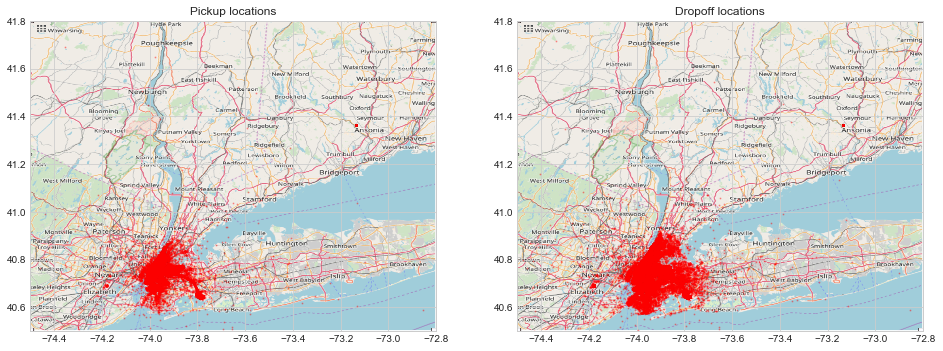

In [0]:
# Training data
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

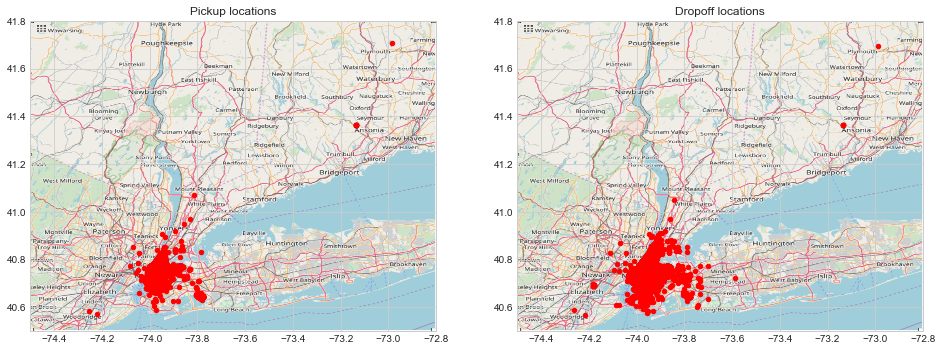

In [0]:
# Test data
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

From the training data scatter plot we see that some locations are in the water. Either these are considered as noise, or we drop them from the dataset. Let's drop them.

<a id='explore_location_water'></a>
#### Removing datapoints in the water

As can be seen from the map + scatter plots above, some datapoints are located in the water. These are obviously noisy datapoints. To remove these datapoints, let's create a boolean land/water map from the NYC map. For this we can used Photoshop to threshold on the blue color of the water and to cleanup the map. The resulting map is show below.

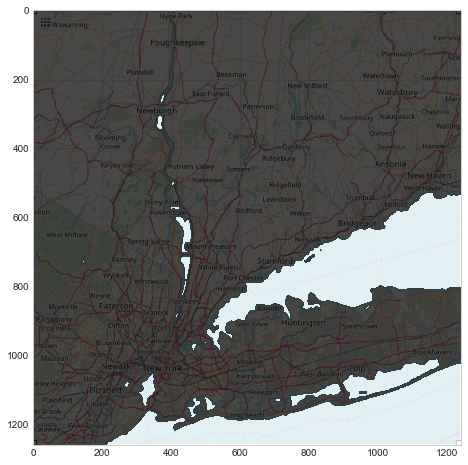

In [0]:
# Eead nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # Note: True is show in black, False in white.

Next, we need to convert longitude/latitude coordinates to xy pixel coordinates. The function lonlat_to_xy implements this transformation. Note that the y coordinate needs to be reversed as the image y-axis is directed from top to bottom.

Once for all datapoints the xy pixel coordinates are calculate a boolean index is calculated using the NYC mask.

In [0]:
# Translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [0]:
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [0]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 85


Let's put all this step in a single function we can reuse when we need to remove datapoints from water

In [0]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [0]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

Old size: 489464
New size: 489379


Let's check that all outliers in the water are gone

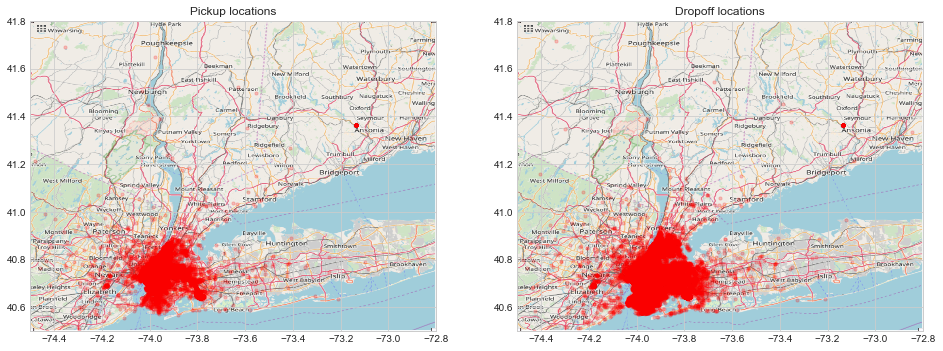

In [0]:
plot_on_map(df_train, BB, nyc_map)

For further exploration of the data refer to the notebook of Albert van Breemen (linked at the beginning of this notebook). From this notebook we can learn that:
- The datapoints concentrate around Manhatten and the three airports (JFK, EWS, LGR). There is also a hotspot near Seymour.
- There are different traffic density patterns by the hour, but also by location. E.g. at sunday h=0-3 hour (saturday night to sunday) there is more traffic than on weekdays.
- Overall there seems to be a (linear) relation between distance and fare with an average rate of +/- 100/20 = 5 USD/mile: the longer the trip is the higher is the fare.
- Some trips, like to/from an airport, are fixed fee
- Fare at night is different from day time
- Fare $USD/mile varies not only over the hours but also over the years
- Fare varies with pickup location, especially from/to the city center and from/to the airports
- The average fare amount in Manhattan depends on the direction

From this information we can conclude that the fare will be a function of the distance, the duration (which depends itself of when the trips will occur due to the periodic congestion), the location of the trip and the number of passengers, except for the trips with fixed fee (depends if the trips are going from/to an airport).

<a id='feature_engineering'></a>
## Feature engineering

<a id='feature_distance'></a>
### Distance

We have to calculate the distance for each trip (which will be used as a feature of our model). Albert van Breemen used the Haversine formula [https://en.wikipedia.org/wiki/Haversine_formula] to calculate the distance between to GPS points. This is better than using the euclidean distance as the Haversine formula takes into accound the shape of the earth but not perfect as this formula still gives a distance point to point. Indeed as showed by Albert van Breemen the  average fare amount in Manhattan depends on the direction, the trips are not following a direct line but are following the roads.

A better approach is therefore to use the Manhattan distance as it is a better approximation of the real distance done by the taxis.

<a id='feature_distance_manhattan'></a>
#### Manhattan distance

We want to use the Manhattan distance to calculate a good approximation of the distance done by the taxis but the issue if that we can only use this distance if the roads are aligned with the horizon (which is not the case as the streets in Manhattan have a angle of about 60 degrees with the horizon).

Therefore we have to correct this angle in order to use the Manhattan distance.

!["Correct "](https://i.imgur.com/ZPlvFzO.png)

This sub-section uses the work realised in this notebook: https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance

In [0]:
# Given a dataframe, add two new features 'abs_diff_longitude' and 'abs_diff_latitude' reprensenting the vector from
# the pickup location to the dropoff location

def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(df_train)

Let's convert *abs_diff_longitude* & *abs_diff_latitude* to kilometers

Since we are calculating this at New York, we can assign a constant, rather than using a formula (fixed for the latitude but depends on the latitude for the longitude):
- For the latitude: degrees of latitude in radians x 111
- For the longitude: degrees of longitude x 79.1 (New York lat: 0.71059 radians x 111.321)

Details here: https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles

In [0]:
def convert_kilometers(train_df):
    train_df['abs_diff_longitude'] = train_df.abs_diff_longitude * 79.1
    train_df['abs_diff_latitude'] = train_df.abs_diff_latitude * 111
    
convert_kilometers(df_train)

In [0]:
### Angle difference between north, and manhattan roadways
meas_ang = 0.506 # 29 degrees = 0.506 radians
import math

## adding extra features
def add_extra_manh_features(df):
    df['euclidean_distance'] = (df.abs_diff_latitude**2 + df.abs_diff_longitude**2)**0.5  
    df['delta_manh_long'] = (df.euclidean_distance*np.sin(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['delta_manh_lat'] = (df.euclidean_distance*np.cos(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['manh_distance'] = df.delta_manh_long + df.delta_manh_lat
    df['euclidean_error'] = (df.manh_distance - df.euclidean_distance)*100 /  df.euclidean_distance

add_extra_manh_features(df_train)

In [0]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,euclidean_distance,delta_manh_long,delta_manh_lat,manh_distance,euclidean_error
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.213649,1.003551,1.026041,0.299527,0.981348,1.280875,24.836596
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2.909298,7.847811,8.369716,1.258961,8.274489,9.533450,13.904101
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.672666,1.188588,1.365731,0.012287,1.365676,1.377963,0.895623
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.350967,2.769339,2.791490,1.035263,2.592421,3.627684,29.955109
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.904904,1.748694,1.968955,0.056050,1.968157,2.024207,2.806185


We added extra information to the dataframe especially information about euclidean and mahnattan distances and the error rate of the euclidean distance comparing to the mahnattan one.

<a id='feature_distance_further'></a>
#### Going further

The issue is that even if the Mahnattan distance is a better approximation of the distance done by the taxis than the euclidean one, it is still not the real one. Ideally we would like to have access to the real distance of the trips. Even if it is not feasible with 100% accuracy we can have a better approximation of the distance than the Mahnattan one thanks to external ressources.

Indeed let's imagine that we can simulated a trip from its pickup location to its dropoff location on a road map of New York we could have a very good approximation of the trip distance (of course it is not a perfect one as the path took by the taxi can change depending on the traffic jam).

To do that we could use the Distance Matrix API from Google [https://developers.google.com/maps/documentation/distance-matrix/intro] that provides us the travel distance and time for a matrix of origins and destinations. It would be the easiest solution but also the more expensive as we have to do a request with all the datapoints (train & test set) [https://developers.google.com/maps/documentation/distance-matrix/usage-and-billing].

A more complex but cheaper (free) solution is to set up an OpenTripPlanner server [http://www.opentripplanner.org/] with the OpenStreetMap of New York and to request it for each datapoint.

<a id='feature_distance_otp'></a>
#### OpenTripPlanner

To start using OpenTripPlanner follow this tutorial: http://docs.opentripplanner.org/en/latest/Basic-Tutorial/

To download the OpenStreetMap area we are interested in (.osm.pbf format) follow this link: https://download.geofabrik.de/north-america/us-northeast.html

## Build the network

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [0]:
model = Sequential()
model.add(Dense(32, input_dim=784))
model.add(Activation('relu'))